In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import os
os.chdir("..")
os.chdir("Preprocessing")
from preprocessing import *
import selfies as sf

#Ensemble learning and random forest

df = preprocessing("C:\\Users\Gilbert\Documents\BCB_Research\Kcat_Benchmark_ML_Models\Data\kcat_transferase.csv")

In [2]:
d = df.copy()

d.head()

data = d

In [3]:
encoded_df = pd.read_csv("C:\\Users\Gilbert\Documents\BCB_Research\Kcat_Benchmark_ML_Models\Data\encoded_amino.csv")


In [4]:
# Assuming encoded_df is your one-hot encoded data from before
amino_pca = PCA(n_components=433)
principal_components = amino_pca.fit_transform(encoded_df)

# Convert to DataFrame for convenience
amino_pca_df = pd.DataFrame(data=principal_components)

In [5]:
data.head()

,EC_number,Species,Compound,Compound_name,Amino_encoding,Kcat,unit
0,2.1.1.1,Homo sapiens,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDFLEKYYKFGSRHSAESQILKHLLKNLF...,0.0410,s^(-1)
1,2.1.1.1,Homo sapiens,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,1.0200,s^(-1)
2,2.1.1.1,Homo sapiens,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,0.0830,s^(-1)
3,2.1.1.10,Brassica oleracea,C(CS)C(C(=O)O)N,L-Homocysteine,MGLEKKSALLEDLIEKCGGCAVVDGGFATQLEIHGAAINDPLWSAV...,0.0375,s^(-1)
4,2.1.1.10,Escherichia coli,C(CS)C(C(=O)O)N,L-Homocysteine,MSQNNPLRALLDKQDILLLDGAMATELEARGCNLADSLWSAKVLVE...,0.3800,s^(-1)


3163    78300.00000
3851    32000.00000
2141    14000.00000
2142    14000.00000
2252    14000.00000
662      8050.00000
810      7000.00000
4061     6666.66667
2748     6600.00000
937      6004.00000
3327     6000.00000
936      5694.00000
1187     5460.00000
929      5252.00000
925      5190.00000
1160     5086.00000
951      4500.00000
935      4412.00000
1181     4080.00000
811      4000.00000
934      3980.00000
3266     3869.00000
933      3595.00000
491      3580.00000
494      3580.00000
931      3453.00000
492      3450.00000
930      3324.00000
928      3217.00000
2992     3204.00000
Name: Kcat, dtype: float64


In [6]:
#preprocessing
#lets encode the data using label encoder 
label_encoder = LabelEncoder()
data["EC_number"] = label_encoder.fit_transform(data["EC_number"])
data["Species"] = label_encoder.fit_transform(data["Species"])

amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
amino_to_index = {amino: i for i, amino in enumerate(amino_acids)}

# Convert amino acid sequences to one-hot encoding
def convert_to_one_hot(sequence, max_length):
    one_hot_sequence = np.zeros((max_length, len(amino_acids)))
    
    for i, amino in enumerate(sequence):
        if amino in amino_to_index:
            index = amino_to_index[amino]
            one_hot_sequence[i, index] = 1
            
    return one_hot_sequence.flatten()

# Determine the maximum sequence length
max_sequence_length = max(len(seq) for seq in data["Amino_encoding"])

# Apply the conversion to the DataFrame column
data["Amino"] = data["Amino_encoding"].apply(lambda seq: convert_to_one_hot(seq, max_sequence_length)).tolist()

# convert compound name into numbers.
compound = data["Compound"]

data["smiles"] = [Chem.MolFromSmiles(smiles) for smiles in compound]

mol = data["smiles"]

def smiles_to_morgan_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
        return fingerprint
    else:
        return None

# Apply logarithmic transformation to 'Kcat'
data["Kcat"] = np.log10(data["Kcat"])  # Applying log(x + 1) to handle zeros


# add molecular weights as a feature

def molecular_weight(compound):
    mol = Chem.MolFromSmiles(compound)
    if mol:
        return Descriptors.MolWt(mol)
    else:
        return none

data["Molecular_Weight"] = data["Compound"].apply(molecular_weight)

#apply log to molecular weight because it is not well distributed

data["Molecular_Weight"] = np.log10(data['Molecular_Weight'])


# add logP values
# Polar Surface Area
# Amino Acid features

# data.drop(columns=["Compound_name", "Amino_encoding","unit"], inplace=True)



[23:49:56] WARNING: not removing hydrogen atom without neighbors
[23:49:56] WARNING: not removing hydrogen atom without neighbors
[23:49:56] WARNING: not removing hydrogen atom without neighbors
[23:49:56] WARNING: not removing hydrogen atom without neighbors


In [7]:
data.head()

# data["Morgan_fingerprint"] = data["Compound"].apply(smiles_to_morgan_fingerprint)

,EC_number,Species,Compound,Compound_name,Amino_encoding,Kcat,unit,Amino,smiles,Molecular_Weight
0,0,99,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDFLEKYYKFGSRHSAESQILKHLLKNLF...,-1.387216,s^(-1),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x000001D9F32...,2.086812
1,0,99,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,0.008600,s^(-1),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x000001D9F32...,2.086812
2,0,99,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,-1.080922,s^(-1),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x000001D9F32...,2.086812
3,1,39,C(CS)C(C(=O)O)N,L-Homocysteine,MGLEKKSALLEDLIEKCGGCAVVDGGFATQLEIHGAAINDPLWSAV...,-1.425969,s^(-1),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x000001D9F32...,2.130938
4,1,81,C(CS)C(C(=O)O)N,L-Homocysteine,MSQNNPLRALLDKQDILLLDGAMATELEARGCNLADSLWSAKVLVE...,-0.420216,s^(-1),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x000001D9F32...,2.130938


In [ ]:
data_features = data.copy()

data_features.drop(columns=["Kcat", "Amino"], inplace=True)

In [ ]:
data_features.head()

In [8]:
# train and split the data
# EC_number, Species, Amino, and fingerprint_rdk

from sklearn.model_selection import train_test_split

# x_features = np.array(data_features['Fingerprint_rdk'].tolist())
# # y = np.array(data["Kcat_normalized"])

# x_features = pd.DataFrame(x_features)

x = amino_pca_df
y = data["Kcat"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [9]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

# Check data types
print("x_train data type:", type(x_train))
print("y_train data type:", type(y_train))



x_train shape: (3308, 433)
y_train shape: (3308,)
x_train data type: <class 'pandas.core.frame.DataFrame'>
y_train data type: <class 'pandas.core.series.Series'>


In [10]:
# this initialization of the regression model
rf_regressor = RandomForestRegressor()

rf_regressor.fit(x_train, y_train)

y_pred = rf_regressor.predict(x_test)

In [ ]:
data.describe()

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)

print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred)) 
print('r2:', r2_score(y_test, y_pred))
print('RMSE:', np.sqrt(mse))


MAE:  0.6333224334080664
MSE:  0.882869518490922
r2: 0.6679885814441662
RMSE: 0.9396113656671687


In [25]:
# Feature importance
importances = rf_regressor.feature_importances_
print("Feature importances:", importances)

Feature importances: [0.00588285 0.00462936 0.00482018 0.00411735 0.01781624 0.01157291
 0.01645421 0.0061109  0.00193378 0.00158725 0.00828247 0.00703976
 0.00510478 0.00187914 0.00498031 0.00431371 0.00462628 0.01032171
 0.00188368 0.00277938 0.00198619 0.0029725  0.00309815 0.00242101
 0.00275241 0.00325876 0.01240607 0.00590064 0.00603071 0.00157086
 0.00417885 0.00516707 0.00237321 0.00152032 0.00268435 0.00239349
 0.00256587 0.00375355 0.00242484 0.00825485 0.00191349 0.00126998
 0.00532228 0.00194294 0.02338462 0.00520033 0.00324675 0.0028144
 0.00186216 0.00342261 0.00171835 0.0025445  0.00446204 0.01508099
 0.00680239 0.00274633 0.00276739 0.00167616 0.00263055 0.00219444
 0.00442873 0.00234882 0.00270804 0.00385741 0.00178091 0.00302922
 0.00546979 0.00290961 0.00298021 0.00302854 0.00321965 0.00161156
 0.00190726 0.00466896 0.00295297 0.00280511 0.00307053 0.00319122
 0.00384702 0.00184239 0.00283894 0.0037092  0.00114901 0.00621466
 0.00296781 0.00151132 0.00118619 0.002300

In [ ]:
from sklearn.model_selection import GridSearchCV

# helps finding the optimal hyperparameters
param_grid = {
    'n_estimators': [100,200,250],
    'max_depth': [1, 10, 20]
    # Add more hyperparameters and values
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3)
grid_search.fit(x_train, y_train)

best_rf_regressor = grid_search.best_estimator_

In [ ]:
grid_search.score(x_train, y_train)

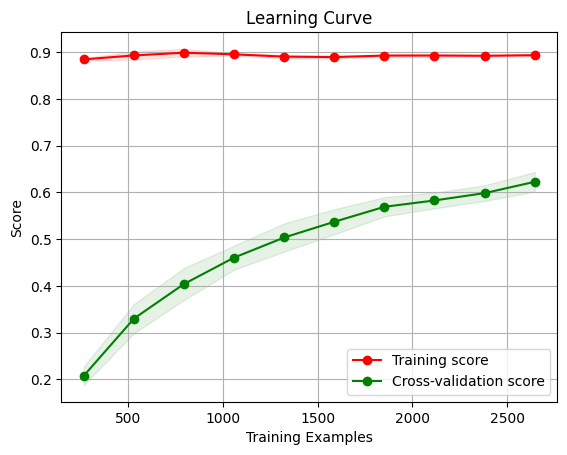

In [10]:
# Create a random forest regressor

from sklearn.model_selection import learning_curve


regressor = RandomForestRegressor(random_state=42)

# Create learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    regressor, x_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation of scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(
    train_sizes, train_scores_mean, "o-", color="r", label="Training score"
)
plt.plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
)

plt.legend(loc="best")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    rf_regressor.set_params(n_estimators=n)
    rf_regressor.fit(x_train, y_train)
    scores.append(rf_regressor.score(x_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Kcat Values')
plt.grid(True)
plt.show()